In [20]:
from dotenv import load_dotenv
load_dotenv()

True

define path to data directory (set in env variables)

In [27]:
datadir=os.environ['DATADIR']

import library of functions for model

In [28]:
import prpatt as prpatt

Find available experiments

Define experiments we will process

In [29]:

expts=['base',
 'ch4x3',
 'bcslt',
 'solar',
 'sulx5',
 'co2x2',
 'cfc12',
 'bcx10',
 'base2',
 'cfc11',
 'n2o1p']

store all experiments in a concatenated xarray dataframe

In [32]:
for i,expt in enumerate(expts):
    tmp=xr.open_dataset(datadir+"training/pdrmip-"+expt+"_T42_ANN.nc")
    if i==0:
        dac=tmp
    else:
        dac=xr.concat([dac,tmp],'expt')

label the experiment dimension with expt names

In [33]:
dac=dac.assign_coords({"expt": expts})
dac

<xarray.Dataset>
Dimensions:  (lon: 128, lat: 64, year: 250, ens: 10, expt: 11)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2095 2096 2097 2098 2099
  * ens      (ens) object 'CanESM2' 'ECHAM-HAM' ... 'NCAR-CESM1-CAM5' 'NorESM1'
    height   float64 2.0
    ht       float32 -1.0
    surface  float32 0.0
  * expt     (expt) <U5 'base' 'ch4x3' 'bcslt' ... 'base2' 'cfc11' 'n2o1p'
Data variables:
    tas      (expt, year, lat, lon, ens) float32 225.3 228.3 226.7 ... nan nan
    pr       (expt, year, lat, lon, ens) float32 1.175e-06 2.184e-06 ... nan nan

Create anomaly matrix from base experiment

In [34]:
ctrl=expts.index("base")

In [35]:
vars=dac.data_vars
dacanom=dac
for var in vars:
    dacanom[var]=dac[var]-dac[var][ctrl,:,:,:,:].mean(dim='year',skipna=True)
dacanom=dacanom.rename({'year': 'time'})

Which fields are we going to process?

In [36]:
flds = ['tas','pr']#[i for i in dacanom.data_vars] 
flds

['tas', 'pr']

list the models we have

In [37]:
mdls=list(dacanom.ens.values)

In [38]:
mdls

['CanESM2',
 'ECHAM-HAM',
 'GISS-E2-R',
 'HadGEM2',
 'HadGEM3',
 'IPSL-CM5A',
 'MIROC-SPRINTARS',
 'MPI-ESM',
 'NCAR-CESM1-CAM5',
 'NorESM1']

define the truncation length for each field we will process

In [39]:
fldtrnc=[2,10]


define the initial guesses for the timescales in the fitb

In [40]:
tmscl=[2,50]

loop through all models, storing results in a dictionary 'od', with heirarchical keys for model, experiment and field
outp are the fitted model parameters
orgoef is the orginal PCA of the data in the experiment
neweof replaces the original PC timeseries with the fitted multi-exponential decay

In [41]:
od=dict()
mav=np.zeros([len(mdls),len(expts),len(flds)])
for i,mdl in enumerate(mdls):
    od[mdl]=dict()

    for j,expt in enumerate(expts):
        od[mdl][expt]=dict()
        for k,fld in enumerate(flds):
            od[mdl][expt][fld]=dict()
            
            X=dacanom[fld][j,:100,:,:,i]
            if ~np.isnan(np.mean(X)):
                print(mdl+' '+expt+' '+fld)
                mav[i,j,k]=1
                (ts,out,us,orgeof,neweof)=prpatt.get_timescales(X,tmscl,fldtrnc[k])
                od[mdl][expt][fld]['neweof']=neweof
                od[mdl][expt][fld]['orgeof']=orgeof
                od[mdl][expt][fld]['outp']=out
                
            else:
                od[mdl][expt][fld]['neweof']=np.nan
                od[mdl][expt][fld]['orgeof']=np.nan

CanESM2 base tas
CanESM2 base pr
CanESM2 ch4x3 tas
CanESM2 ch4x3 pr
CanESM2 solar tas
CanESM2 solar pr
CanESM2 sulx5 tas
CanESM2 sulx5 pr
CanESM2 co2x2 tas
CanESM2 co2x2 pr
CanESM2 bcx10 tas
CanESM2 bcx10 pr
ECHAM-HAM base tas
ECHAM-HAM base pr
ECHAM-HAM bcslt tas
ECHAM-HAM bcslt pr
ECHAM-HAM cfc12 tas
ECHAM-HAM cfc12 pr
ECHAM-HAM bcx10 tas
ECHAM-HAM bcx10 pr
ECHAM-HAM base2 tas
ECHAM-HAM base2 pr
ECHAM-HAM cfc11 tas
ECHAM-HAM cfc11 pr
ECHAM-HAM n2o1p tas
ECHAM-HAM n2o1p pr
GISS-E2-R base tas
GISS-E2-R base pr
GISS-E2-R ch4x3 tas
GISS-E2-R ch4x3 pr


/uio/kant/div-cicero-u1/bensan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/uio/kant/div-cicero-u1/bensan/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


GISS-E2-R bcslt pr
GISS-E2-R solar tas
GISS-E2-R solar pr
GISS-E2-R sulx5 tas
GISS-E2-R sulx5 pr
GISS-E2-R co2x2 tas
GISS-E2-R co2x2 pr
GISS-E2-R cfc12 tas
GISS-E2-R cfc12 pr
GISS-E2-R bcx10 tas
GISS-E2-R bcx10 pr
HadGEM2 base tas
HadGEM2 base pr
HadGEM2 ch4x3 tas
HadGEM2 ch4x3 pr
HadGEM2 solar tas
HadGEM2 solar pr
HadGEM2 sulx5 tas
HadGEM2 sulx5 pr
HadGEM2 co2x2 tas
HadGEM2 co2x2 pr
HadGEM2 cfc12 tas
HadGEM2 cfc12 pr
HadGEM2 bcx10 tas
HadGEM2 bcx10 pr
HadGEM2 base2 tas
HadGEM2 base2 pr
HadGEM2 cfc11 tas
HadGEM2 cfc11 pr
HadGEM2 n2o1p tas
HadGEM2 n2o1p pr
HadGEM3 base tas
HadGEM3 base pr
HadGEM3 ch4x3 tas
HadGEM3 ch4x3 pr
HadGEM3 solar tas
HadGEM3 solar pr
HadGEM3 sulx5 tas
HadGEM3 sulx5 pr
HadGEM3 co2x2 tas
HadGEM3 co2x2 pr
HadGEM3 cfc12 tas
HadGEM3 cfc12 pr
HadGEM3 bcx10 tas
HadGEM3 bcx10 pr
IPSL-CM5A base tas
IPSL-CM5A base pr
IPSL-CM5A ch4x3 tas
IPSL-CM5A ch4x3 pr
IPSL-CM5A solar tas
IPSL-CM5A solar pr
IPSL-CM5A sulx5 tas
IPSL-CM5A sulx5 pr
IPSL-CM5A co2x2 tas
IPSL-CM5A co2x2 pr
IP

Sanity check - plot global mean values for original data, eof reconstruction (should be very similar to org data), and multi-timescale fit

no data


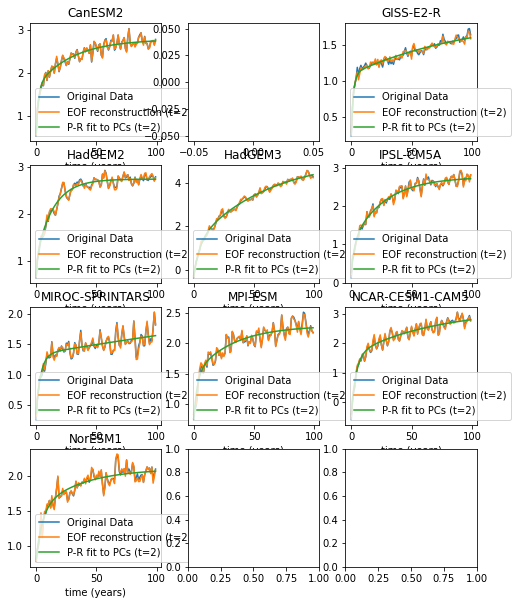

In [48]:

p,ax=plt.subplots(4,3)
ax=ax.flatten()
p.set_size_inches(8,10)
for i,mdl in enumerate(mdls):
    X=dacanom[fld][expts.index(expt),:100,:,:,mdls.index(mdl)]
    ax[i].plot(prpatt.global_mean(X),label='Original Data')
    try:
        ax[i].plot(prpatt.global_mean(prpatt.recon(od[mdl][expt][fld]['orgeof'])),label='EOF reconstruction (t=2)')
        ax[i].plot(prpatt.global_mean(prpatt.recon(od[mdl][expt][fld]['neweof'])),label='P-R fit to PCs (t=2)')
        ax[i].set_xlabel('time (years)')
        ax[i].legend()
        ax[i].set_title(mdl)
    except:
        print('no data')


Look at the EOFs themselves

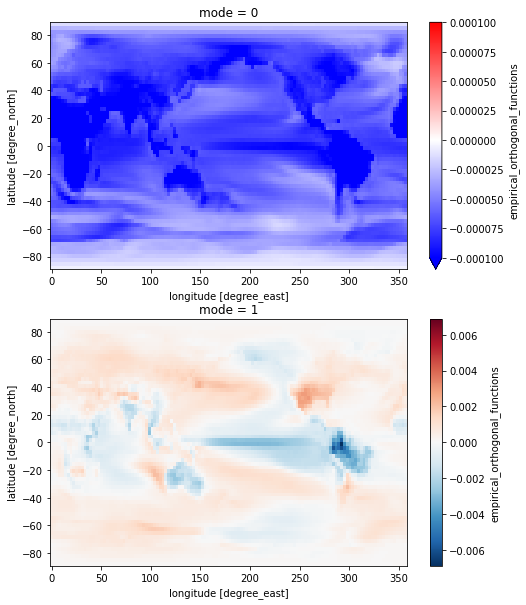

In [49]:

p,ax=plt.subplots(2,1)
p.set_size_inches(8,10)
plt.set_cmap('bwr')
od['CanESM2']['co2x2']['tas']['orgeof']['v'][0,:,:].plot(ax=ax[0],cmap='bwr',vmin=-0.0001,vmax=0.0001)
od['CanESM2']['co2x2']['tas']['orgeof']['v'][1,:,:].plot(ax=ax[1])



In [50]:
od['CanESM2']['co2x2']['tas'].keys()

dict_keys(['neweof', 'orgeof', 'outp'])

Detailed look at CanESM

In [51]:
#original data
Xp=dacanom['tas'][expts.index('co2x2'),:100,:,:,mdls.index('CanESM2')]
#reconstructed data from EOFs
Xrp=prpatt.recon(od['CanESM2']['co2x2']['tas']['orgeof'])
#reconstructed data from EOF patterns and timescale fit
Xrs=prpatt.recon(od['CanESM2']['co2x2']['tas']['neweof'])



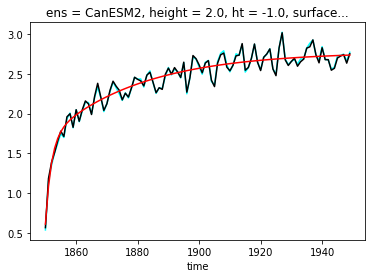

In [52]:
Xp.weighted(prpatt.wgt(Xp)).mean(('lat','lon')).plot(color='cyan')
Xrp.weighted(prpatt.wgt(Xp)).mean(('lat','lon')).plot(color='k')
Xrs.weighted(prpatt.wgt(Xp)).mean(('lat','lon')).plot(color='red')



Look at emulated and actual response, year 150

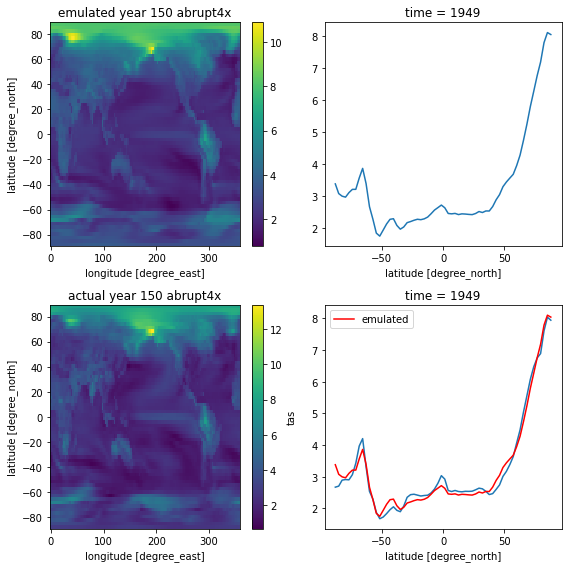

In [60]:
p,ax=plt.subplots(2,2)
p.set_size_inches(8,8)
Xrs[-1,:,:].plot(ax=ax[0,0])
Xrs[-1,:,:].mean(dim='lon').plot(ax=ax[0,1])

ax[0,0].set_title('emulated year 150 abrupt4x')
Xp[-1,:,:].plot(ax=ax[1,0])
Xp[-1,:,:].mean(dim='lon').plot(ax=ax[1,1])
Xrs[-1,:,:].mean(dim='lon').plot(ax=ax[1,1],color='r',label='emulated')
ax[1,1].legend()
ax[1,0].set_title('actual year 150 abrupt4x')

p.tight_layout()


Look at response to an idealised forcing profile

In [55]:
#define a gaussian forcing profile

f=5*np.exp(-np.square(np.arange(0,300)-150)/5000)


Text(0.5, 1.0, 'Idealised overshoot forcing')

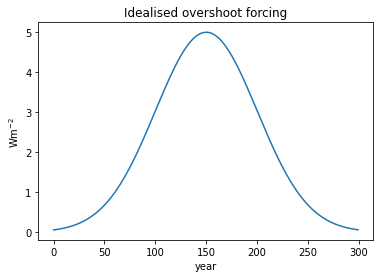

In [56]:
plt.plot(f)
plt.ylabel(r'Wm$^{-2}$')
plt.xlabel('year')
plt.title('Idealised overshoot forcing')

Use the emulator to compute response to idealised forcing

In [58]:
out=od['CanESM2']['co2x2']['tas']['outp']
outp=od['CanESM2']['co2x2']['pr']['outp']
orgeof=od['CanESM2']['co2x2']['tas']['orgeof']
orgeofp=od['CanESM2']['co2x2']['pr']['orgeof']



Xup=prpatt.imodel_eof(outp.params, f)
Xfp=prpatt.imodel_filter(outp.params,f)
Xsimp=prpatt.rmodel(orgeofp,Xfp)

Xu=prpatt.imodel_eof(out.params, f)
Xf=prpatt.imodel_filter(out.params,f)
Xsim=prpatt.rmodel(orgeof,Xf)



plot delay in temperature and precip response, relative to forcing

Text(0.5, 1.0, 'CanESM2 METEOR fit')

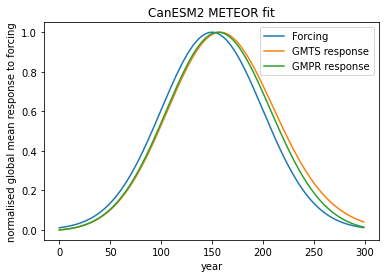

In [60]:
ts_f=Xsim.weighted(prpatt.wgt(X)).mean(('lat','lon'))
pr_f=Xsimp.weighted(prpatt.wgt(X)).mean(('lat','lon'))

plt.plot(f/np.max(f),label='Forcing')
plt.plot(ts_f/np.max(ts_f),label='GMTS response')
plt.plot(pr_f/np.max(pr_f),label='GMPR response')
#p1=Xsim.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
#Xact=ds_1pc_anom.tas[0,:150,:,:]

#p2=Xact.weighted(prpatt.wgt(X)).mean(('lat','lon')).plot()
plt.ylabel('normalised global mean response to forcing')
plt.xlabel('year')
plt.legend()

plt.title('CanESM2 METEOR fit')
#plt.legend((p1[0],p2[0]),['Emulated','truth'])

plot hysteresis of precipitation change as a function of forcing

Text(0.5, 1.0, 'CanESM2 METEOR emulation')

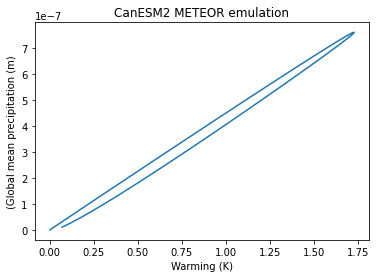

In [62]:
plt.plot(ts_f,pr_f)


plt.ylabel(r'(Global mean precipitation (m)')
plt.xlabel('Warming (K)')
plt.title('CanESM2 METEOR emulation')
